In [1]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms
import torch.nn as nn

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [2]:
from torch_fidelity import calculate_metrics
input1 = '/home/diwenxu2/xray_latent2im/20k_images'
input2 = '/home/diwenxu2/covid/COVID-19_Radiography_Dataset/COVID'
# Each input can be either a string (path to images, registered input), or a Dataset instance
metrics_dict = calculate_metrics(input1, input2, cuda=True, isc=True, fid=True, kid=True, verbose=True)

print(metrics_dict)
# Output:
# {
#     'inception_score_mean': 11.23678, 
#     'inception_score_std': 0.09514061, 
#     'frechet_inception_distance': 18.12198,
#     'kernel_inception_distance_mean': 0.01369556, 
#     'kernel_inception_distance_std': 0.001310059
# }

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "/home/diwenxu2/xray_latent2im/20k_images" with extensions png,jpg,jpeg
Found 20000 samples
Processing samples                                                             
Extracting features from input_2
Looking for samples non-recursivelty in "/home/diwenxu2/covid/COVID-19_Radiography_Dataset/COVID" with extensions png,jpg,jpeg
Found 3616 samples
Processing samples                                                           
Computing Inception Score
Computing Frechet Inception Distance
                                                                                           

{'inception_score_mean': 2.4483177902383213, 'inception_score_std': 0.039333405291402064, 'frechet_inception_distance': 32.5513900159072, 'kernel_inception_distance_mean': 0.022846673285785775, 'kernel_inception_distance_std': 0.0014956681222905344}


Computing Kernel Inception Distance


In [20]:
from classifier import Classifier
from torch.nn import DataParallel
from easydict import EasyDict as edict
from torch.utils.data import DataLoader

In [8]:
transform = transforms.Compose([
 transforms.ToTensor()
])

In [4]:
pwd

'/home/diwenxu2/xray_latent2im'

In [21]:
g_path = '/home/diwenxu2/checkpoint/620000.pt'
reg_json = '/home/diwenxu2/logdir_ori/cfg.json'
reg_path = '/home/diwenxu2/logdir_ori/best.ckpt'
device = 'cuda'

In [22]:
with open(reg_json) as f:
    cfg = edict(json.load(f))

In [23]:
model = Classifier(cfg)
ckpt = torch.load(reg_path)
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [24]:
model = model.cuda()
model.eval()

Classifier(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum

In [41]:
model = models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load('covid_classifier.ckpt'))

<All keys matched successfully>

In [42]:
model = model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [43]:
transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
        ])

In [44]:
def analysis(image_path,model):
    
    image = Image.open(image_path).convert('RGB')
    transformed_img = transform(image)
    transformed_img = transformed_img.to('cuda')
    image = transformed_img.unsqueeze(0).cuda()
    output = torch.sigmoid(model(image))
#     preds = output.ge(0.5).float()
    print(output)
#     print(preds)
#     print("Cardiomegaly: 0, Edema: 1, Consolidation: 2, Atelectasis: 3, Effusion: 4")
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
          
    occlusion = Occlusion(model)

    attributions_occ = occlusion.attribute(image,
                                       strides = (3, 8, 8),
                                       target=1,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

In [48]:
normal_path = '/home/diwenxu2/xray_latent2im/model_Covid/stylegan_v2_xray_linear_lr0.0001_l2_w/images/w_1_seed12_Covid_max0.0_min0.0_sample3_0.49.png'
covid_path = '/home/diwenxu2/xray_latent2im/model_Covid/stylegan_v2_xray_linear_lr0.0001_l2_w/images/w_1_seed12_Covid_max1.0_min1.0_sample5_0.02.png'

tensor([[0.1059, 0.9081]], device='cuda:0', grad_fn=<SigmoidBackward>)


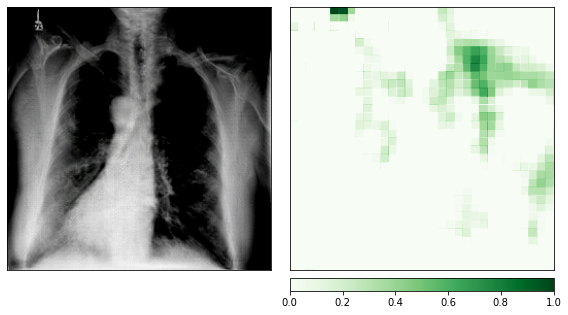

In [49]:
analysis(covid_path,model)

tensor([[0.7554, 0.2435]], device='cuda:0', grad_fn=<SigmoidBackward>)


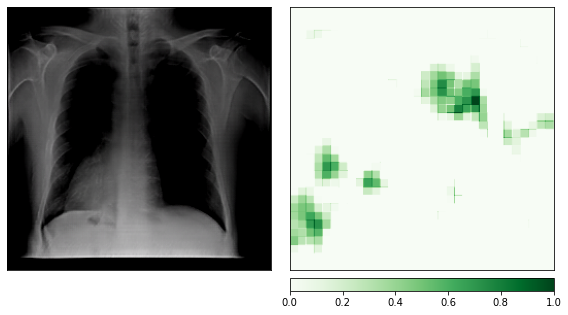

In [47]:
analysis(normal_path,model)

In [34]:
#Cardiomegaly
image_path = '/home/diwenxu2/xray_latent2im/model_Consolidation/stylegan_v2_xray_linear_lr0.0001_l2_w/images/w_1_seed12_Consolidation_max1.0_min1.0_sample4_0.45.png'

tensor([[0.3099, 0.3763, 0.5614, 0.5581, 0.7886]])


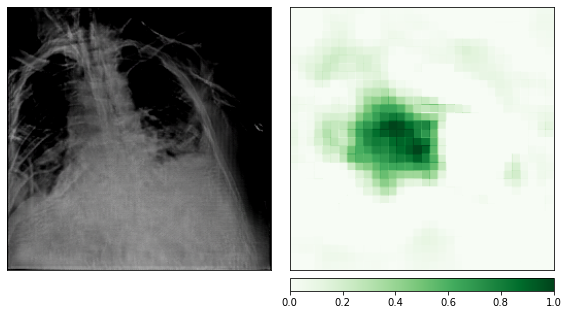

In [33]:
analysis(image_path,model)

tensor([[0.3989, 0.4125, 0.5745, 0.5184, 0.7566]])


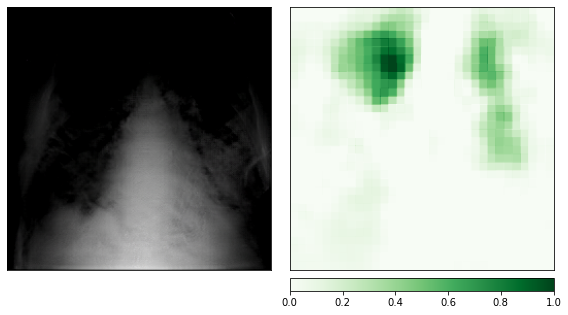

In [39]:
analysis(image_path,model)

tensor([[0.2387, 0.2186, 0.4238, 0.4073, 0.4091]])
Cardiomegaly: 0, Edema: 1, Consolidation: 2, Atelectasis: 3, Effusion: 4


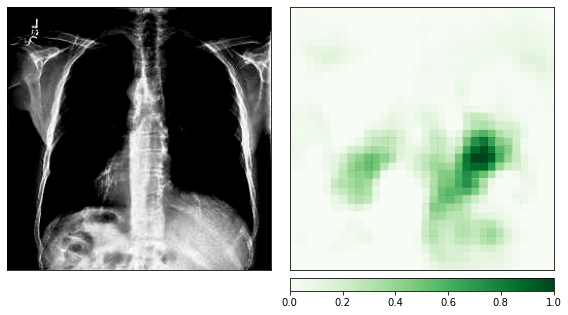

In [32]:
analysis(image_path,model)

tensor([[0.2394, 0.2331, 0.4370, 0.4212, 0.4268]])
Cardiomegaly: 0, Edema: 1, Consolidation: 2, Atelectasis: 3, Effusion: 4


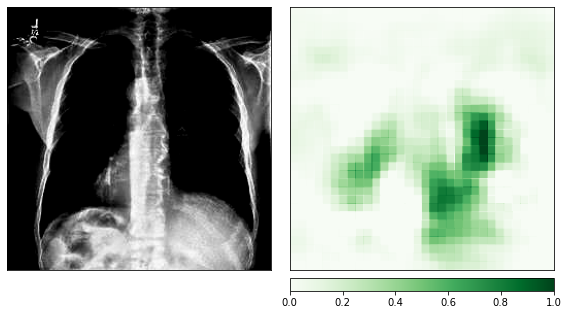

In [15]:
# Edema
image_path = '/home/diwenxu2/xray_latent2im/model_Ed/stylegan_v2_xray_linear_lr0.0001_l2_w/images/org_img/w_1_seed12_Edema_max1.0_min0.0_sample22_0.22_org.jpg'
analysis(image_path,model)

tensor([[0.3348, 0.3377, 0.4780, 0.5315, 0.5915]])
Cardiomegaly: 0,Edema: 1,Consolidation: 2,Atelectasis: 3,Effusion: 4


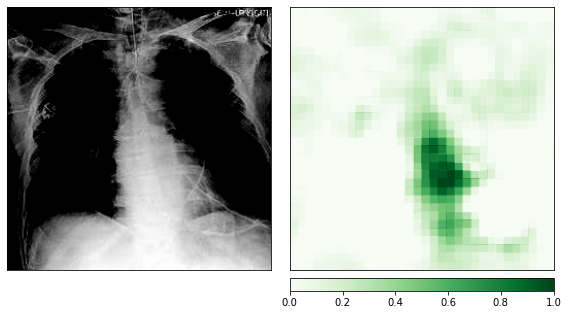

In [15]:
# Consolidation
image_path = '/home/diwenxu2/xray_latent2im/model_Consolidation/stylegan_v2_xray_linear_lr0.0001_l2_w/images/org_img/w_1_seed12_Consolidation_max0.7_min0.0_sample9_0.48_org.jpg'
analysis(image_path,model)

tensor([[0.2446, 0.2396, 0.4469, 0.4330, 0.4551]])
Cardiomegaly: 0,Edema: 1,Consolidation: 2,Atelectasis: 3,Effusion: 4


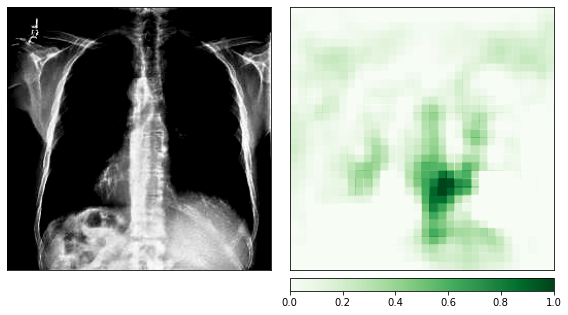

In [16]:
# Atelectasis
image_path = '/home/diwenxu2/xray_latent2im/model_At/stylegan_v2_xray_linear_lr0.0001_l2_w/images/org_img/w_1_seed12_Atelectasis_max0.7_min0.0_sample22_0.44_org.jpg'
analysis(image_path,model)

tensor([[0.2398, 0.2035, 0.4041, 0.4423, 0.4098]])
Cardiomegaly: 0,Edema: 1,Consolidation: 2,Atelectasis: 3,Effusion: 4


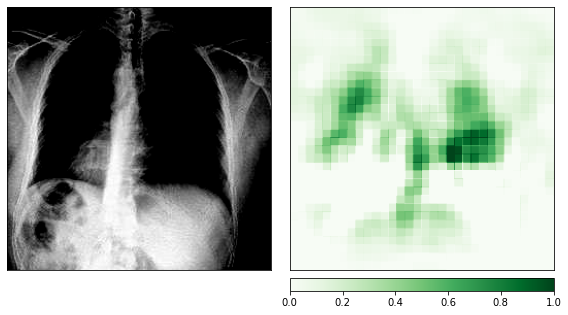

In [17]:
# Effusion
image_path = '/home/diwenxu2/xray_latent2im/model_Effusion/stylegan_v2_xray_linear_lr0.0001_l2_w/images/org_img/w_1_seed12_Effusion_max0.7_min0.0_sample23_0.42_org.jpg'
analysis(image_path,model)

tensor([[0.2997, 0.2711, 0.4174, 0.3979, 0.3556]])
Cardiomegaly: 0,Edema: 1,Consolidation: 2,Atelectasis: 3,Effusion: 4


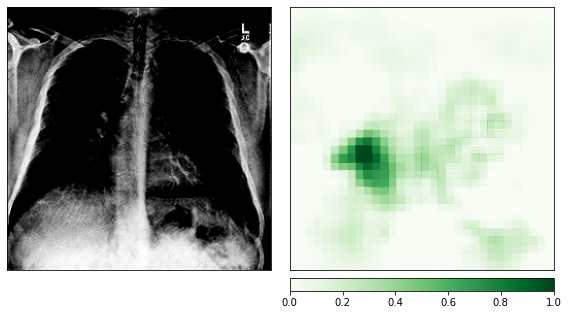

In [18]:
# implement the classifier on Cardiomegaly (alpha = 0)
image_path = '/home/diwenxu2/xray_latent2im/model_At/stylegan_v2_xray_linear_lr0.0001_l2_w/images/w_1_seed12_Atelectasis_max0.0_min0.0_sample20_0.48.png'
analysis(image_path,model)

tensor([[0.4915, 0.3641, 0.4566, 0.4616, 0.5789]])
Cardiomegaly: 0,Edema: 1,Consolidation: 2,Atelectasis: 3,Effusion: 4


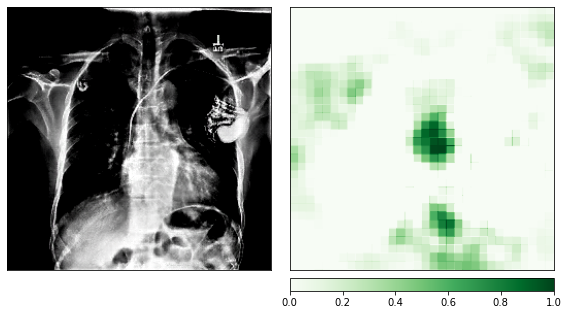

In [21]:
# implement the classifier on Cardiomegaly (alpha = 0.3)
image_path = '/home/diwenxu2/xray_latent2im/model_At/stylegan_v2_xray_linear_lr0.0001_l2_w/images/w_1_seed12_Atelectasis_max0.3_min0.3_sample18_0.53.png'
analysis(image_path,model)

tensor([[0.3385, 0.2531, 0.4808, 0.5567, 0.6535]])
Cardiomegaly: 0,Edema: 1,Consolidation: 2,Atelectasis: 3,Effusion: 4


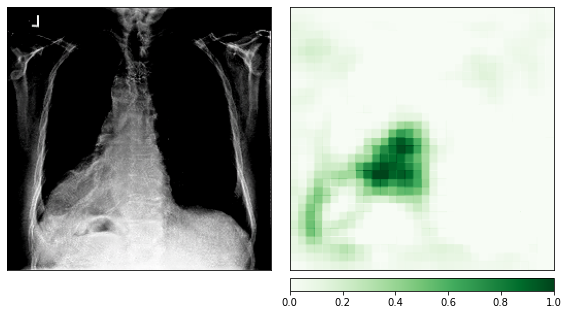

In [20]:
# implement the classifier on Cardiomegaly (alpha = 0.7)
image_path = '/home/diwenxu2/xray_latent2im/model_At/stylegan_v2_xray_linear_lr0.0001_l2_w/images/w_1_seed12_Atelectasis_max0.7_min0.7_sample24_0.48.png'
analysis(image_path,model)